## Machine Learning Nanodegree - Capstone Project
### Who is in the photo?
The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning. To have a comparison model, I will use a base line model. This model will be the best of two options:

* EigenFaces with PCA and SVM
* OpenCV pre trained Classifiers 


### First, Load and Clean up the dataset 

In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 83)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('../faces/train')
valid_files, valid_targets = load_face_dataset('../faces/valid')
test_files, test_targets = load_face_dataset('../faces/test')


person_names = [item[12:-1] for item in sorted(glob("../faces/train/*/"))]


print(str(len(train_files)))
print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

Using TensorFlow backend.


11071
There are 83 total person names.
There are 13823 total face images.

There are 11071 training face images.
There are 1364 validation face images.
There are 1388 test face images.


In [2]:
def person_path(path):
    path_split = path.split('/')
    path_split.pop()
    return '/'.join(path_split)

def limit_training_images(paths, images_per_person=10):
    paths = list(paths)
    paths.sort()
    
    current_path = person_path(paths[0])
    count = 0
    limited_paths = []
    for path in paths:
        if current_path != person_path(path):
            count = 0
            current_path = person_path(path)
        if count <= images_per_person:
            limited_paths.append(path)
            count += 1
    return limited_paths
        

#### Convert image data to array

In [6]:
import cv2
from keras.preprocessing import image # just to transform array to img 
from scipy.misc import imread
from scipy.misc import imresize
from tqdm import tqdm

haar_cascade_path = '../project/haarcascades/haarcascade_frontalface_default.xml'
detector= cv2.CascadeClassifier(haar_cascade_path);

def extract_face(img):
    img = img.astype(np.uint8)
    faces = detector.detectMultiScale(img)
    if len(faces)> 0:
        x,y,w,h =  faces[0]
        img = img[y:y+h,x:x+w]
        img = image.array_to_img(img)
        img = img.resize((100,100))
        img = image.img_to_array(img)
        return img
    return []



def load_image_from(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)
    img = np.expand_dims(img, axis=2)
    face = extract_face(img)
    if len(face) == 0:
        return img
    else:
        return face


def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load data to train, test and validation

In [7]:
base_train_images = load_images_from(train_files).astype('float32')/255
base_test_images = load_images_from(test_files).astype('float32')/255
base_valid_images = load_images_from(valid_files).astype('float32')/255

100%|██████████| 1364/1364 [00:08<00:00, 162.97it/s]


### Explore and normalize the dataset

#### A set of functions to help visualize and normalize the dataset

In [8]:
import matplotlib.pyplot as plt                        

def get_image_from_normalized(normalized_vector, height, width):
    return np.reshape(normalized_vector,[height,width])

def show_images(dataset,height,width,cols=10,scale=1, rows_count=None):
    """ display a grid of images}
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(dataset)[0]
    if rows_count:
        n = rows_count 
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/height*width,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(get_image_from_normalized(dataset[i,:], height, width), cmap = plt.get_cmap("gray"))
        plt.axis('off')

In [9]:
from PIL import Image       
import glob
import math

def image_to_vector(image_paths, H,W):
    image_count = len(image_paths)
    # and columns as pixels
    not_faces = []
    faces = []
    arr = np.zeros([image_count,H*W])
    for i in tqdm(range(image_count)):
#         im = Image.open(image_paths[i]).convert("L")
        im = cv2.imread(image_paths[i])
        face = extract_face(im)
        if len(face) > 0:
            im = face
            faces.append(image_paths[i])
        else:
            not_faces.append(image_paths[i])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        arr[i,:] = np.reshape(np.asarray(im),[1,H*W])
    print "Sem Faces: "+str(len(not_faces))
    print "com Faces: "+str(len(faces))
    
    return arr

In [10]:
def extract_mean(images):
    return np.mean(images, axis=0)


In [11]:
def centralize(images, mean_image, H,W):
    im_number = len(images)
    
    arr_norm = np.zeros([im_number, H*W])
    arr_norm = images - mean_image
    return arr_norm

#### Load the train files into a vector and show some images examples

  0%|          | 16/11071 [00:00<01:10, 156.80it/s]

('shape: ', (100, 100))


100%|██████████| 11071/11071 [01:09<00:00, 159.83it/s]


Sem Faces: 300
com Faces: 10771


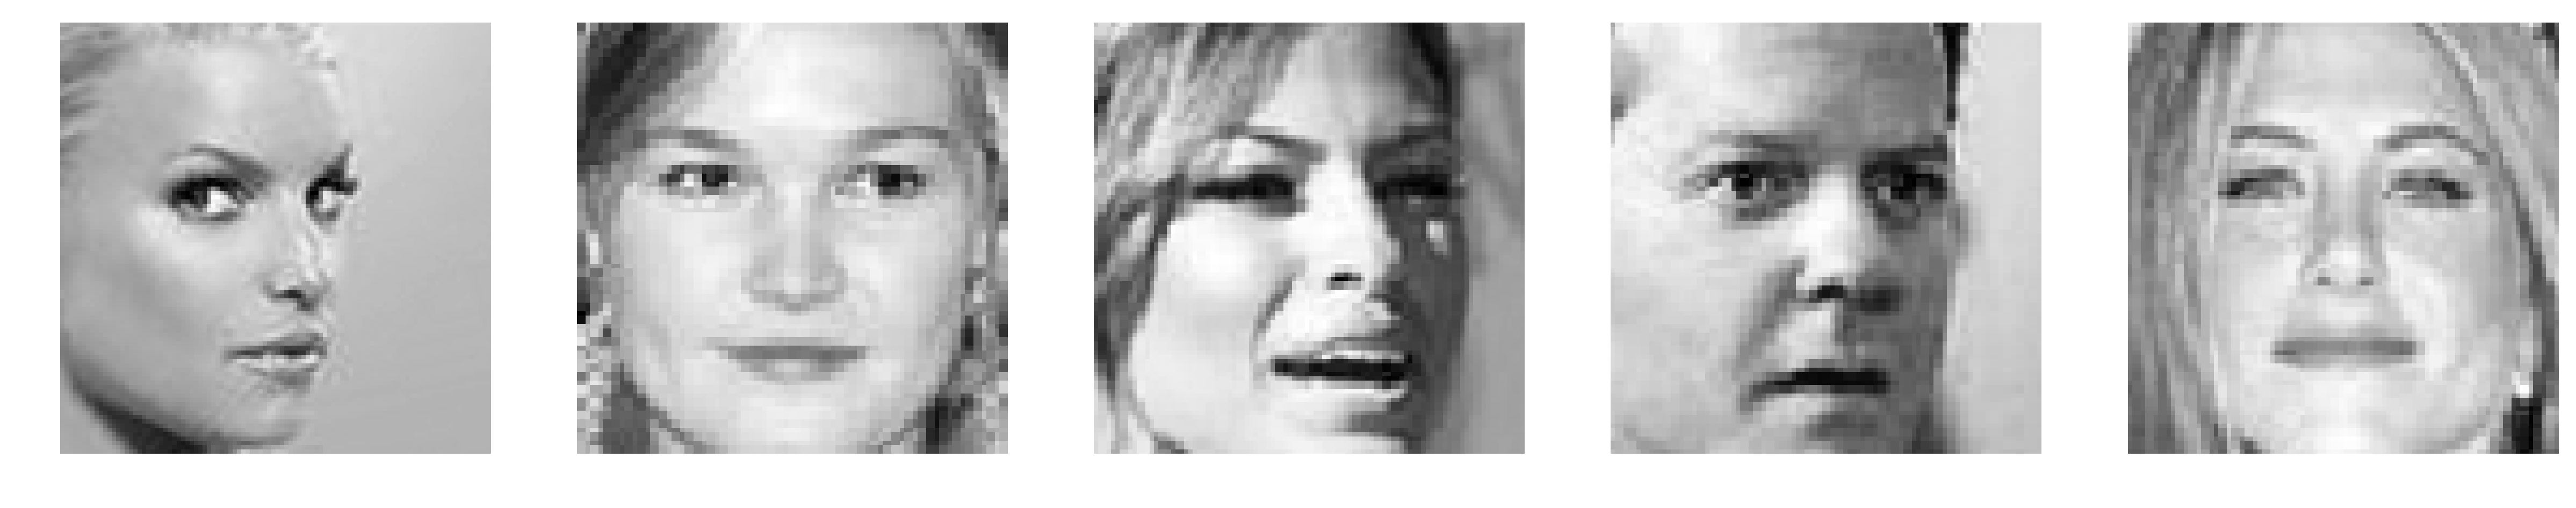

In [12]:
file_list = train_files
im = Image.open(file_list[4]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

dataset = image_to_vector(train_files, H,W)

show_images(dataset,H,W,cols=5,rows_count=5)



### Normalize the dataset

The process of normalizing the dataset consists of two basic activities: Extract an array with the average representation of all images and center the images in the dataset.

#### Extract and visualize the mean

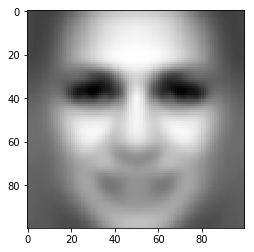

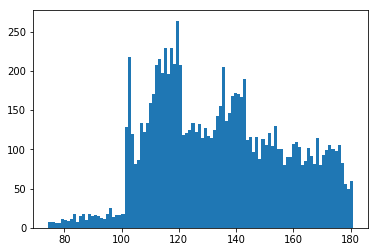

In [13]:
mean_image = extract_mean(dataset)

plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);

#### Centralize the dataset

In [14]:
dataset_normalized = centralize(dataset, mean_image, H,W)

#### Examples of image from the normalized dataset

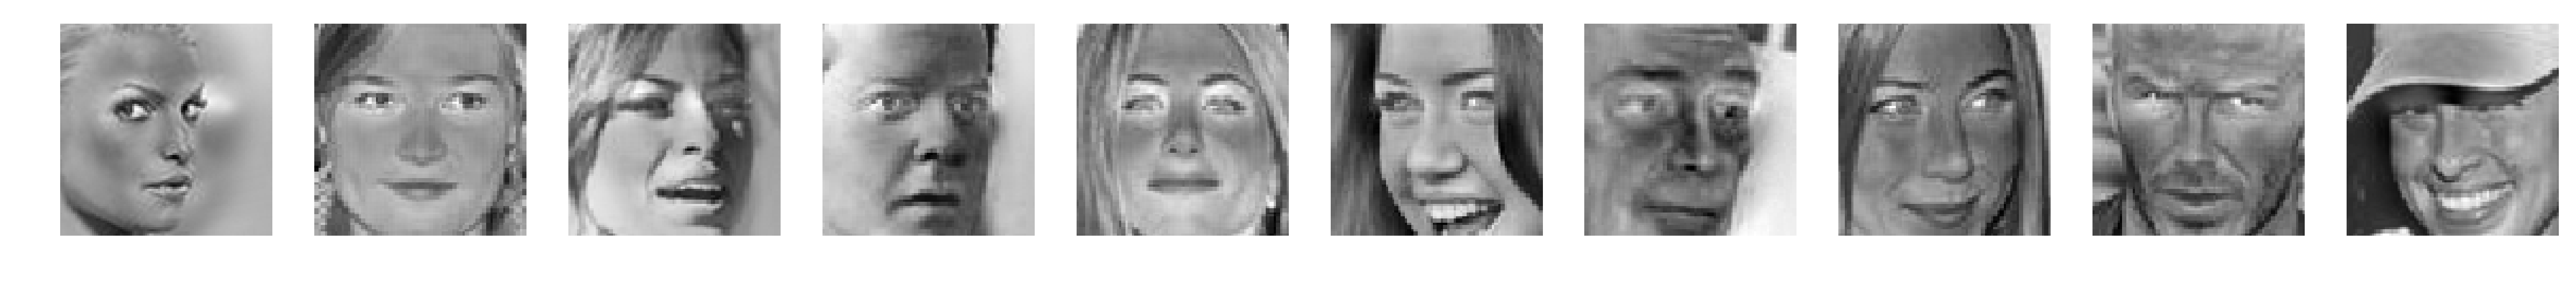

In [15]:
show_images(dataset_normalized[:10,:],H,W)

### 1 - Train a PCA + Eingenfaces + SVM model

#### Load libraries

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


#### Lookup table
This auxiliary function, returns a list with the array index of the targets tha represents the correct image.

In [17]:
def create_lookup_table(targets):
    lookup = []
    for target in targets:
        index = np.where(target==1)[0]
        lookup.append(index[0])
    return np.array(lookup)

In [18]:
base_train_targets = create_lookup_table(train_targets)
base_test_targets = create_lookup_table(test_targets)
base_valid_targets = create_lookup_table(valid_targets)


####  Creating a function to execute the PCA

In [19]:
def execute_pca(train, test, n_components):
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(train)

    print("done in %0.3fs" % (time() - t0))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca, pca


#### Creating a function to train the model with SVM
This funcition use GridSearchCV to find the best param combination to the data.

In [20]:
def apply_svm(X_train, y_train):
    # Train a SVM classification model
    print("Fitting the classifier to the training set")
    param_grid = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
    }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf


#### Training the model
After some feature engineering, now we can train the model and check the results  .

In [21]:
X_train = base_train_images
y_train = base_train_targets

X_test  = base_test_images
y_test  = base_test_targets

In [22]:
im = Image.open(test_files[0]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

X_test = image_to_vector(test_files,H,W)
mean_test = extract_mean(X_test)
X_test = centralize(X_test, mean_test, H,W)
print(dataset_normalized.shape)
print(X_test.shape)

X_train_pca, X_test_pca, pca= execute_pca(dataset_normalized, X_test, n_components=160)

  1%|          | 14/1388 [00:00<00:10, 132.57it/s]

('shape: ', (100, 100))


100%|██████████| 1388/1388 [00:08<00:00, 169.90it/s]


Sem Faces: 28
com Faces: 1360
(11071, 10000)
(1388, 10000)
Extracting the top 160 eigenfaces from 11071 faces
done in 43.474s
Projecting the input data on the eigenfaces orthonormal basis
done in 2.849s


#### Plot Scree Plot of PCA

The scree plot is useful to visualize the proportion of the variations explained by pca components.

Text(0.5,0,u'Principal Component Number')

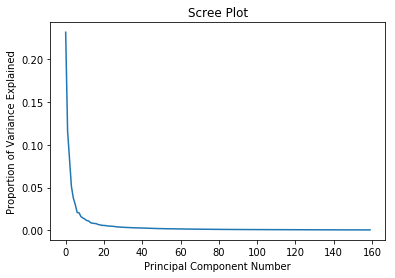

In [23]:
# Let's make a scree plot
pve = pca.explained_variance_ratio_
pve.shape
plt.plot(range(len(pve)), pve)
plt.title("Scree Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")


In this case, the first 20 components account for most of the total variability in the data. The remaining components account for a very small proportion of variability.

#### Eigenfaces
The eigenvectors of the variance-covariance matrix of our "face" data represent the so-called "eigenfaces". They represent the direction of greatest variability in our "face space". We plot the first 9 eigenfaces here.

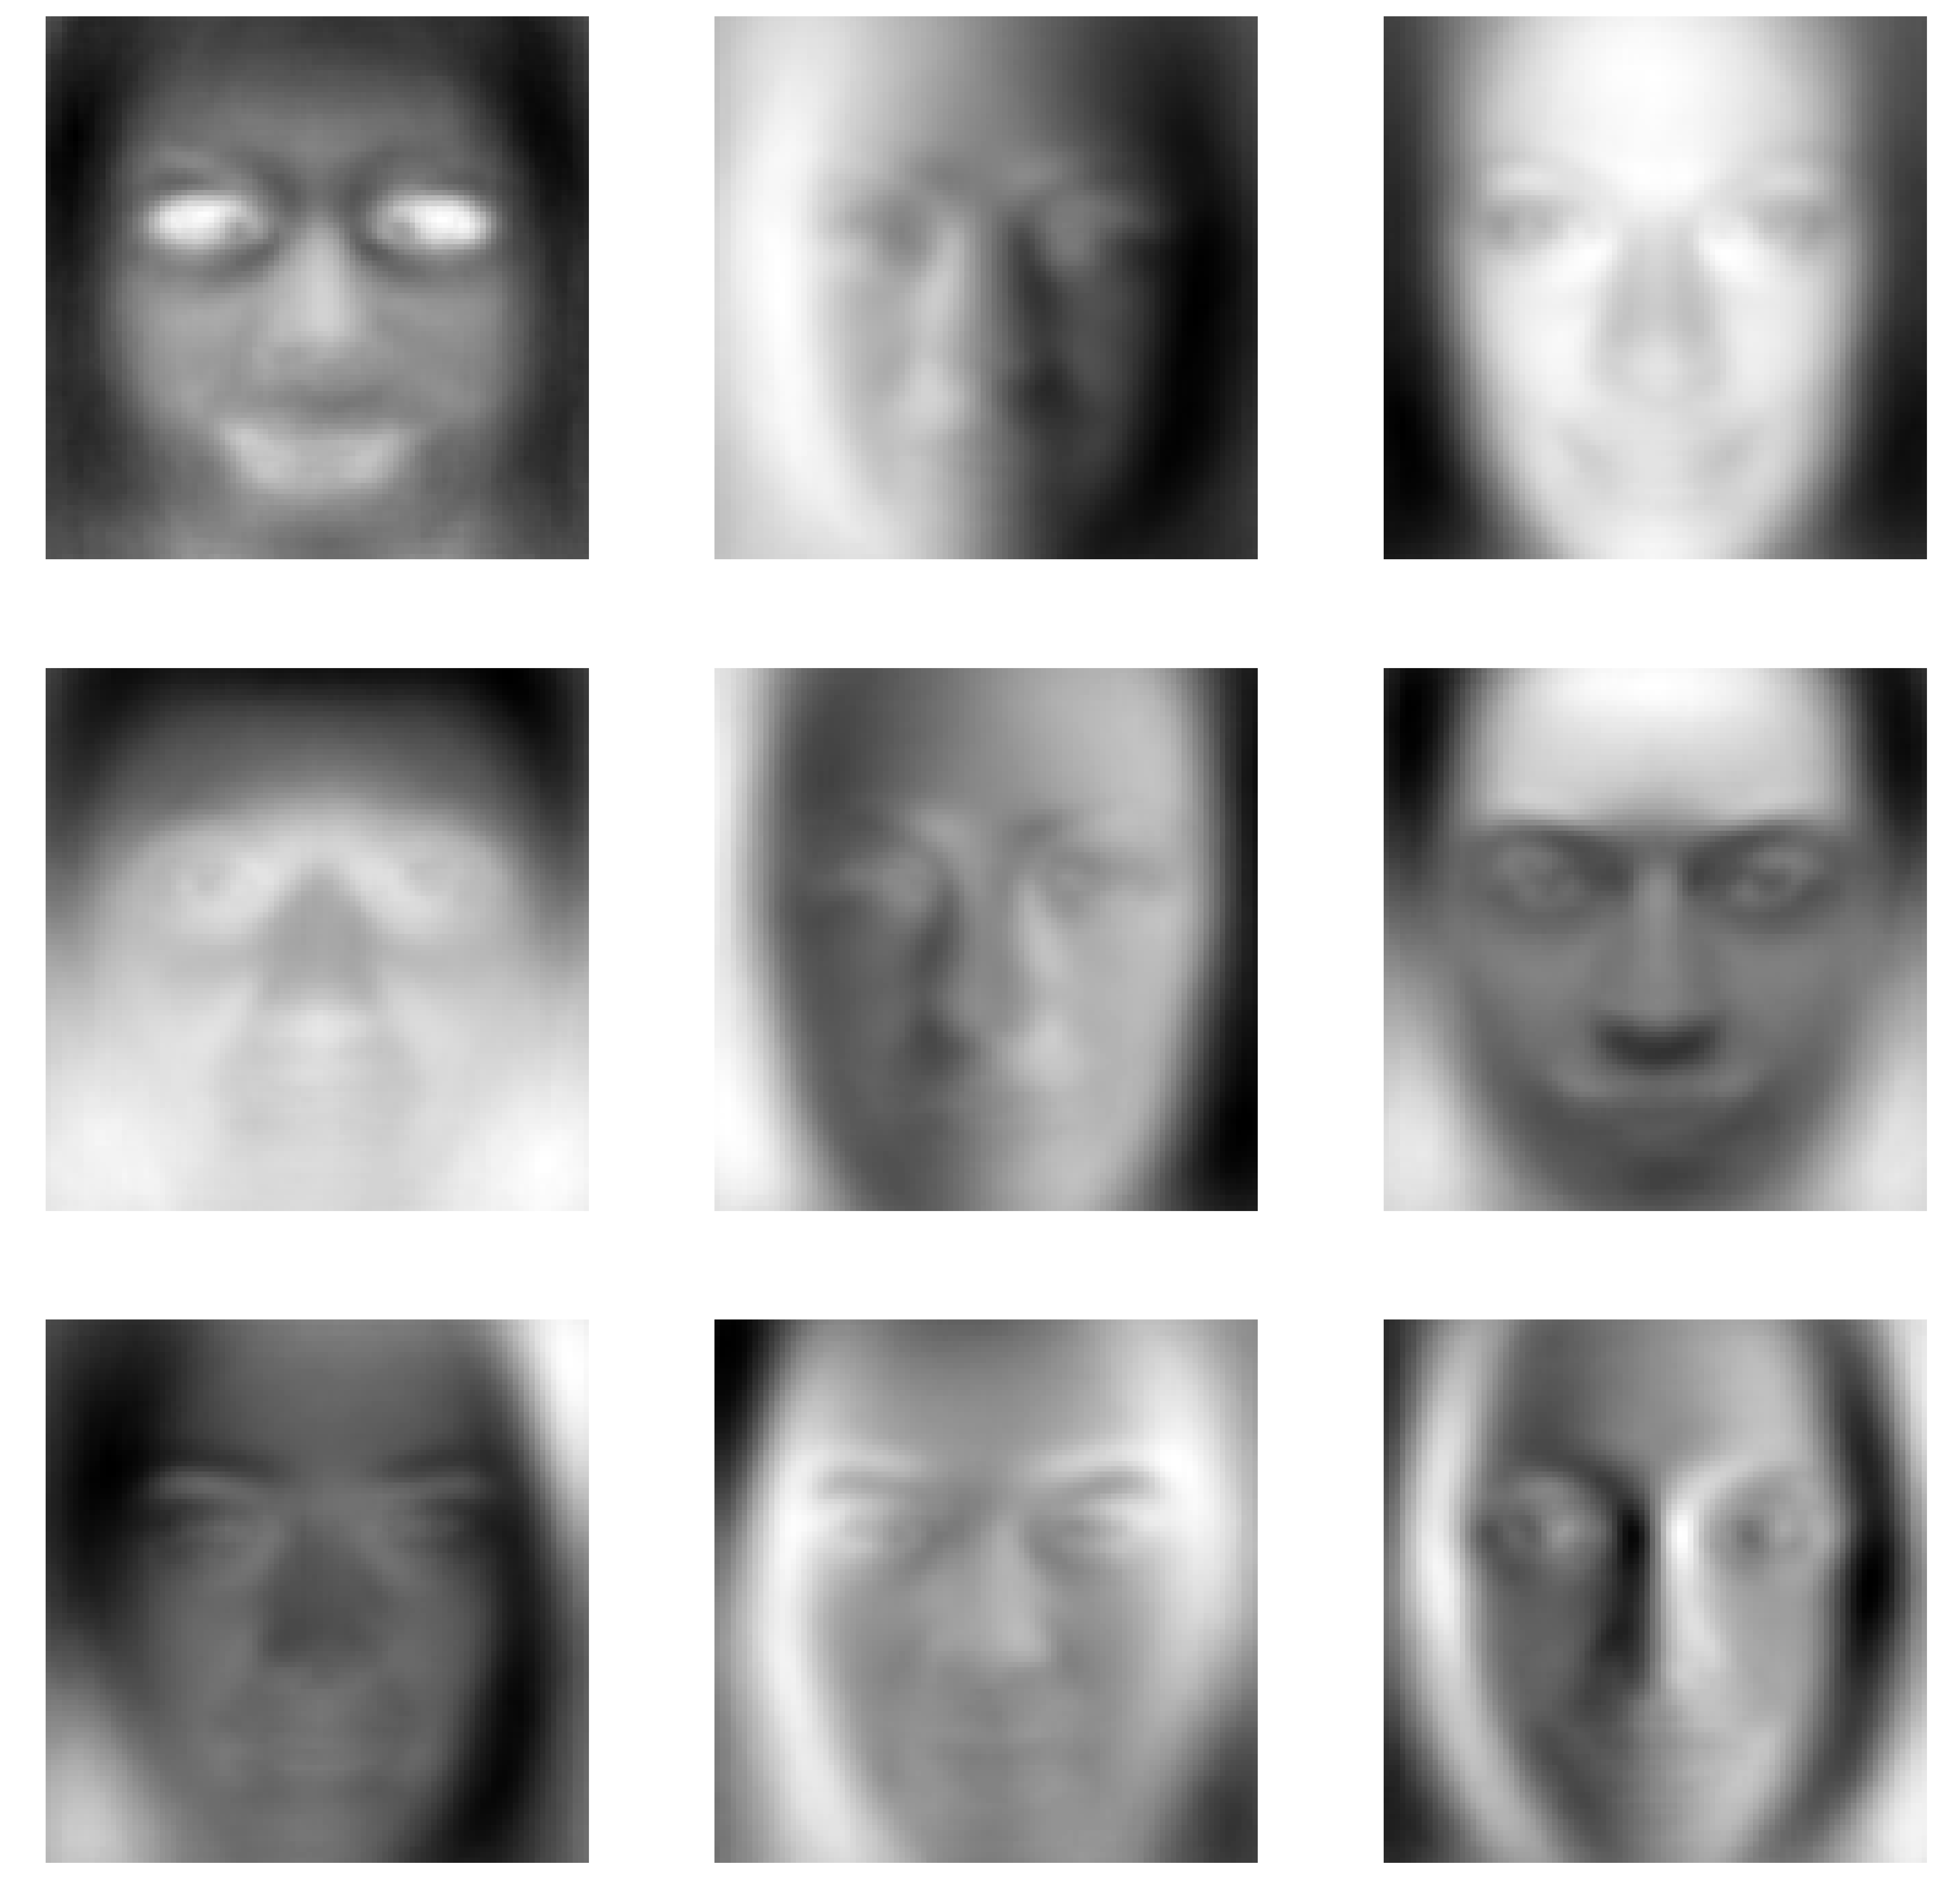

In [24]:
eigenfaces = pca.components_
show_images(eigenfaces[:9,:], H, W, cols=3)

#### Train a SVM with PCA data

In [65]:
clf = apply_svm(X_train_pca, y_train)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Check accuracy of the model

In [66]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=person_names))

print(confusion_matrix(y_test, y_pred, labels=range(len(person_names))))


                         precision    recall  f1-score   support

        in/Adam Sandler       0.70      0.64      0.67        11
        in/Alec Baldwin       0.89      0.80      0.84        10
      in/Angelina Jolie       0.20      0.43      0.27        21
     in/Anna Kournikova       0.41      0.41      0.41        17
      in/Ashton Kutcher       0.42      0.50      0.45        10
       in/Avril Lavigne       0.36      0.53      0.43        30
        in/Barack Obama       0.51      0.70      0.59        27
         in/Ben Affleck       0.56      0.42      0.48        12
     in/Beyonce Knowles       0.36      0.38      0.37        13
           in/Brad Pitt       0.30      0.43      0.35        30
        in/Cameron Diaz       0.48      0.60      0.54        25
      in/Cate Blanchett       0.30      0.38      0.33        16
     in/Charlize Theron       0.35      0.35      0.35        20
     in/Christina Ricci       0.33      0.43      0.38        14
    in/Claudia Schiffer 

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.50576368876080691

### Conclusion

This model achieved 50% of accuracy. 

### 1 - Train an OpenCV classifier with Haar Cascade features

#### Trainning the classifier

In [8]:
haar_cascade_path = '/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml'

In [29]:
def train_classifier(paths, train_targets, person_names):
    images = []
    labels = []
    description_labels = {}
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    #recognizer = cv2.face.FisherFaceRecognizer_create()
    # recognizer = cv2.face.EigenFaceRecognizer_create(num_components=80)
    index = 0    
    original = list(paths)
    for path in tqdm(paths):
        face = load_image_from(path)

        index = original.index(path)
        id = train_targets[index]
        description_labels[id] = person_names[id]
        images.append(face)
        labels.append(id)

    print("training data...", str(len(images)))
    print("labels", len(labels))
    
    recognizer.train(images, np.array(labels))
    print('saving...')
    recognizer.save('train/trainer.yml')
    print('finished')
    return recognizer, description_labels, images, labels


In [30]:
recognizer, labels, images,labels_list = train_classifier(train_files, base_train_targets, person_names)


100%|██████████| 11071/11071 [01:10<00:00, 156.84it/s]


('training data...', '11071')
('labels', 11071)
saving...
finished


#### Checking the accuracy of the model

In [31]:
def check(paths, recognizer, labels, base_test_targets, person_names):
    index = 0
    accuracy_list = []
    messages = []
    original = list(paths)
    for path in tqdm(paths):
        face = load_image_from(path)
        if len(face) > 0:
            predicted_label,conf = recognizer.predict(face)
            index = original.index(path)
            actual_person  = person_names[base_test_targets[index]]
            if predicted_label not in labels.keys():
                messages.append("{} != Unknown person".format(actual_person))
                accuracy_list.append(0)
            else:
                predicted_person = labels[predicted_label]
                if predicted_person == actual_person:
                    messages.append("{0} == {1} - correct prediction".format(actual_person, predicted_person))
                    accuracy_list.append(1)
                else:
                    messages.append("{0} != {1} - incorrect prediction".format(actual_person, predicted_person))
                    accuracy_list.append(0)

    print "Total: {}".format(len(accuracy_list))
    # selectjust the faces predicted correctly
    accuracy_list = np.array(accuracy_list)
    found = np.where(accuracy_list == 1)
    print "Found: {}".format(len(found[0]))
    #calculates the accuracy 
    accuracy = float(len(found[0])) / len(accuracy_list)
    print "Accuracy is {}".format(accuracy)
    #   eigenfaces = 0.138606676343
    #   fisher faces = 0.0972423802612

    return messages


In [32]:
messages= check(test_files,recognizer,labels,base_test_targets,person_names)


100%|██████████| 1388/1388 [16:27<00:00,  1.41it/s]

Total: 1388
Found: 611
Accuracy is 0.440201729107
